In [1]:
import numpy as np
from multiprocessing import Manager,Process
from matplotlib import pyplot as plt

import qubits
import bell_state
import jupyter_function

Send message base on pure state (classic prototype: use state vector)

In [2]:
#Alice and Bob know state_ab, Alice gets qubit_a, Bob has qubit_b
state_ab = "00"

#Alice set message in qubit_c state (0 or 1)
message = 1
qubit_c = qubits.get_qubit_matrix([message])

#Alice do bell measurement on qubit_c and qubit_a to build entangled relationship
#and this operation change the state of qubit_b base on qubit_c at the same time
#then Alice send measurement result in traditional communication method to Bob
qubit_b,state_ca = bell_state.teleportation(qubit_c,state_ab)

#Bob use gates on qubit_b base on the measurement result
#how to choose gates: 
#    measurement result is base on entangled relationship between qubit_c and qubit_a which is same like the relationship between qubit_a and qubit_b
#    which means that how the measurement result changed from state_ab to state_bc is same like the state that qubit_c changed to qubit_b
#    so when Bob know the state_ab and state_ca, he could find the way to restore state_ab from state_ca
#    and he could do the same operation on qubit_b to restore the state of orignal qubit_c and get the message
qubit_b = bell_state.unitary_operation(qubit_b, 0, state_ca, state_ab)
state_b = qubits.measurement(qubit_b,[0])[0]
print("qubit_c(sender):{} | measurement_ca(send):{} | qubit_b(receiver):{}".format(message, state_ca, state_b))

qubit_c(sender):1 | measurement_ca(send):00 | qubit_b(receiver):1


Send message base on superposition state (message in probability)

In [3]:
batch_n = 10 ** 4
state_ab = "00"
message = 7
decode_key = 5
qubit_c = qubits.normalization(np.array([[message],
                                         [decode_key]]))
receive = {"0":0,"1":0}
print("encode_qubit_c:\n{}".format(qubit_c))

#receive different state_ca and measure qubit_b for many times, qubit_b is superposition state
qubit_b, state_ca = bell_state.teleportation(qubit_c, state_ab)
qubit_b = bell_state.unitary_operation(qubit_b, 0, state_ca, state_ab)
for i in range(batch_n):
    state_b = qubits.measurement(qubit_b, [0])[0]
    receive[state_b] = receive[state_b]+1
print(receive)
receive_message = decode_key/receive["1"]*receive["0"]
print("message(sender):{}(decimal) = {}(binary bit) | batch of qubit:{} | decode_probability(receiver):{} => {}".format(message,len(bin(message).split("0b")[-1]),batch_n,receive_message,round(receive_message)))

encode_qubit_c:
[[0.81373347]
 [0.58123819]]
{'0': 7948, '1': 2052}
message(sender):7(decimal) = 3(binary bit) | batch of qubit:10000 | decode_probability(receiver):19.366471734892787 => 19


In [4]:
def test_message_in_superposition_state(message=1,decode_key=1,index_test_n = 1000,index_list = range(0, 7),thread_number=8,state_ab="00"):
    qubit_c = qubits.normalization(np.array([[message],
                                             [decode_key]]))
    qubit_b, state_ca = bell_state.teleportation(qubit_c, state_ab)
    qubit_b = bell_state.unitary_operation(qubit_b, 0, state_ca, state_ab)

    accuracy_list = []
    for i in index_list:
        # multi_thread
        thread_n = thread_number
        task_manager = Manager()
        result_queue = task_manager.Queue(thread_n)
        submit_total = 0
        task_list = []
        for t_i in range(thread_n):
            if t_i is not thread_n - 1:
                submit_n = int(index_test_n / thread_n)
            else:
                submit_n = index_test_n - submit_total
            task = Process(target=jupyter_function.multi_thread_measurement,
                           args=[submit_n, message, i, qubit_b, decode_key, result_queue])
            task.start()
            task_list.append(task)
            submit_total += submit_n
        for task in task_list:
            task.join()
            task.close()

        wrong_n = 0
        for r_i in range(result_queue.qsize()):
            wrong_n += result_queue.get()
        accuracy = (index_test_n - wrong_n) / index_test_n
        accuracy_list.append(accuracy)
    return accuracy_list

In [5]:
thread_number = 40
accuracy_3_4 = test_message_in_superposition_state(message = 9,decode_key = 5,index_test_n = 1000,index_list = range(0, 7),thread_number=thread_number)
accuracy_6_7 = test_message_in_superposition_state(message = 99,decode_key = 50,index_test_n = 1000,index_list = range(0, 7),thread_number=thread_number)

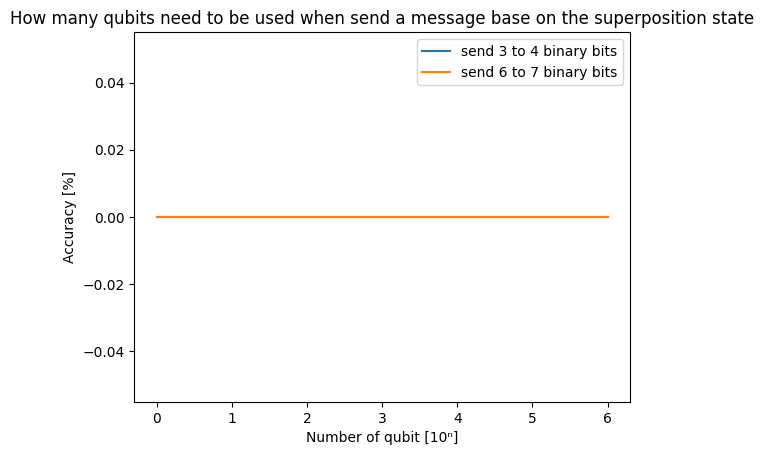

In [6]:
plt.plot(range(0, 7), np.array(accuracy_3_4)*100, label="send 3 to 4 binary bits")
plt.plot(range(0, 7), np.array(accuracy_6_7)*100, label="send 6 to 7 binary bits")
plt.ylabel("Accuracy [%]")
plt.xlabel("Number of qubit [10ⁿ]")
plt.title("How many qubits need to be used when send a message base on the superposition state")
plt.legend()
plt.show()

Conclusion: using superposition state to send message would waste a lot of qubit which is a bad idea to send nomal infomation

Send message base on classic state (massage encode as 0 or 1)

In [7]:
message = "Hello World!"
print("[Send]:{}".format(message))
message_encode = format(int(bytes(message, 'utf-8').hex(), base=16), 'b')
print("[Encode]:{}".format(message_encode))

[Send]:Hello World!
[Encode]:10010000110010101101100011011000110111100100000010101110110111101110010011011000110010000100001


In [8]:
receive_buffer=""
for m in message_encode:
    state_ab = "10"
    qubits_ab = qubits.get_qubit_matrix(state_ab)
    qubit_c = qubits.get_qubit_matrix([m])
    qubit_b,state_ca = bell_state.teleportation(qubit_c,state_ab,[0.0])
    
    qubit_b = bell_state.unitary_operation(qubit_b, 0, state_ca, state_ab)
    state_b = qubits.measurement(qubit_b,[0])[0]
    receive_buffer += state_b
    print("qubit_c(sender):{} | measurement_ca(send):{} | qubit_b(receiver):{}".format(m, state_ca, state_b))

qubit_c(sender):1 | measurement_ca(send):10 | qubit_b(receiver):1
qubit_c(sender):0 | measurement_ca(send):11 | qubit_b(receiver):0
qubit_c(sender):0 | measurement_ca(send):11 | qubit_b(receiver):0
qubit_c(sender):1 | measurement_ca(send):10 | qubit_b(receiver):1
qubit_c(sender):0 | measurement_ca(send):10 | qubit_b(receiver):0
qubit_c(sender):0 | measurement_ca(send):00 | qubit_b(receiver):0
qubit_c(sender):0 | measurement_ca(send):10 | qubit_b(receiver):0
qubit_c(sender):0 | measurement_ca(send):00 | qubit_b(receiver):0
qubit_c(sender):1 | measurement_ca(send):00 | qubit_b(receiver):1
qubit_c(sender):1 | measurement_ca(send):10 | qubit_b(receiver):1
qubit_c(sender):0 | measurement_ca(send):10 | qubit_b(receiver):0
qubit_c(sender):0 | measurement_ca(send):11 | qubit_b(receiver):0
qubit_c(sender):1 | measurement_ca(send):00 | qubit_b(receiver):1
qubit_c(sender):0 | measurement_ca(send):10 | qubit_b(receiver):0
qubit_c(sender):1 | measurement_ca(send):00 | qubit_b(receiver):1
qubit_c(se

In [9]:
print("[Receive]:{}".format(receive_buffer))
message_decode = bytes.fromhex(format(int(receive_buffer, base=2), 'x')).decode('utf-8')
print("[Decode]:{} ({} binary bit)".format(message_decode,len(receive_buffer)))

[Receive]:10010000110010101101100011011000110111100100000010101110110111101110010011011000110010000100001
[Decode]:Hello World! (95 binary bit)


Calculation base on density matrix (has more information compare with state vector, such as coherence)

In [10]:
state_ab = "00"
message = 1
density_c = qubits.get_density_matrix(qubits.get_qubit_matrix([message]))
density_b,state_ca = bell_state.teleportation(density_c,state_ab)
density_b = bell_state.unitary_operation(density_b, 0, state_ca, state_ab)
state_b = qubits.measurement(density_b,[0])[0]
print("qubit_c(sender):\n{}\nmeasurement_ca(send):{}\nqubit_b(receiver):\n{}".format(density_c, state_ca, density_b))

qubit_c(sender):
[[0. 0.]
 [0. 1.]]
measurement_ca(send):11
qubit_b(receiver):
[[0. 0.]
 [0. 1.]]
